In [1]:
import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

# Import necessary libraries
import nltk
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
from collections import Counter
import re
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.stats import pearsonr
import joblib
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn, wordnet as wn
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.tokenize import sent_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/somamohanty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/somamohanty/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/somamohanty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/somamohanty/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/somamohanty/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Load the data
shoe_data=pd.read_csv('review.csv')
shoe_data.head()

,url,product_name,reviewer_name,review_title,review_text,review_rating,verified_purchase,review_date,helpful_count,uniq_id,scraped_at
0,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Jocelyn McSayles,Love em,Love these. Was looking for converses and thes...,5.0,True,Reviewed in the United States on 2 June 2020,2 people found this helpful,36eae4e5-2894-5279-a0b7-d2b330e2b814,24/12/2021 02:26:25
1,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Kenia Rivera,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,True,Reviewed in the United States on 28 October 2021,NaN,f4778bb8-3070-5cb1-b5aa-ffce41a97b57,24/12/2021 02:26:25
2,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Chris Souza,Good quality,Good quality,5.0,True,Reviewed in the United States on 20 January 2021,NaN,db5a7525-d40b-5265-84d8-df4f29837a3b,24/12/2021 02:26:25
3,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Amazon Customer,Good,Great,5.0,True,Reviewed in the United States on 22 April 2021,NaN,75a42851-6462-54b5-988a-27d336221943,24/12/2021 02:26:25
4,https://www.amazon.co.uk/dp/B08SW434MG,"GUESS Women's Bradly Gymnastics Shoe, White, 7 UK",Graziella,PERFETTE!!,Ho scelto il modello bianco con rifinitura die...,5.0,True,Reviewed in Italy on 2 April 2021,2 people found this helpful,232dee43-849e-5d06-ba05-efb3f4814714,24/12/2021 02:26:25


In [3]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return None  # Return None if detection fails

# Create a new column with detected languages
shoe_data['language'] = shoe_data['review_text'].apply(detect_language)

# Filter only  rows with english review
shoe_data = shoe_data[shoe_data['language'] == 'en']

# Drop the language column
shoe_data = shoe_data.drop(columns=['language'])

shoe_data.head()

,url,product_name,reviewer_name,review_title,review_text,review_rating,verified_purchase,review_date,helpful_count,uniq_id,scraped_at
0,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Jocelyn McSayles,Love em,Love these. Was looking for converses and thes...,5.0,True,Reviewed in the United States on 2 June 2020,2 people found this helpful,36eae4e5-2894-5279-a0b7-d2b330e2b814,24/12/2021 02:26:25
1,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Kenia Rivera,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,True,Reviewed in the United States on 28 October 2021,NaN,f4778bb8-3070-5cb1-b5aa-ffce41a97b57,24/12/2021 02:26:25
2,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Chris Souza,Good quality,Good quality,5.0,True,Reviewed in the United States on 20 January 2021,NaN,db5a7525-d40b-5265-84d8-df4f29837a3b,24/12/2021 02:26:25
3,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Amazon Customer,Good,Great,5.0,True,Reviewed in the United States on 22 April 2021,NaN,75a42851-6462-54b5-988a-27d336221943,24/12/2021 02:26:25
14,https://www.amazon.co.uk/dp/B07S1XM3L7,"adidas Women's Retrorun Shoes Running, Core Bl...",Lindsay,Perfect right outta the box,True to size. If between I'd probably go with ...,5.0,True,Reviewed in Canada on 20 October 2021,One person found this helpful,b64632c5-6f24-51eb-9275-6614fed29f1a,24/12/2021 02:26:25


In [4]:
shoe_data.to_csv('final_review.csv', index=False)

In [5]:
shoe_data=pd.read_csv('final_review.csv')
shoe_data.head()

,url,product_name,reviewer_name,review_title,review_text,review_rating,verified_purchase,review_date,helpful_count,uniq_id,scraped_at
0,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Jocelyn McSayles,Love em,Love these. Was looking for converses and thes...,5.0,True,Reviewed in the United States on 2 June 2020,2 people found this helpful,36eae4e5-2894-5279-a0b7-d2b330e2b814,24/12/2021 02:26:25
1,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Kenia Rivera,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,True,Reviewed in the United States on 28 October 2021,NaN,f4778bb8-3070-5cb1-b5aa-ffce41a97b57,24/12/2021 02:26:25
2,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Chris Souza,Good quality,Good quality,5.0,True,Reviewed in the United States on 20 January 2021,NaN,db5a7525-d40b-5265-84d8-df4f29837a3b,24/12/2021 02:26:25
3,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Amazon Customer,Good,Great,5.0,True,Reviewed in the United States on 22 April 2021,NaN,75a42851-6462-54b5-988a-27d336221943,24/12/2021 02:26:25
4,https://www.amazon.co.uk/dp/B07S1XM3L7,"adidas Women's Retrorun Shoes Running, Core Bl...",Lindsay,Perfect right outta the box,True to size. If between I'd probably go with ...,5.0,True,Reviewed in Canada on 20 October 2021,One person found this helpful,b64632c5-6f24-51eb-9275-6614fed29f1a,24/12/2021 02:26:25


In [6]:
# Load the data
brand_df = pd.read_csv('brands.csv')

# Normalize text
shoe_data['product_name'] = shoe_data['product_name'].str.lower().str.strip()
brand_df['Brand Name'] = brand_df['Brand Name'].str.lower().str.strip()

# Convert brand names to a list
brand_names = brand_df['Brand Name'].tolist()

# Function to extract brand name
def extract_brand(product_name):
    for brand in brand_names:
        if re.search(rf'\b{re.escape(brand)}\b', product_name):  # Match whole words
            return brand.capitalize()
    return "Unknown"  # If no match is found

# Apply the function to the product names
shoe_data['brand_name'] = shoe_data['product_name'].apply(lambda x: extract_brand(x))

# Define product names to remove
products_to_remove = [
    "wallniture palla ball organizers and storage for soccer ball & basketballs metal rack set of 5 white",
    "womens mens water shoes kids barefoot quick-dry sports beach swim slip-on aqua sport socks purple cloud size: 13-14 women/10.5-11 men"
]

# Remove rows with the specified product names
shoe_data = shoe_data[~shoe_data['product_name'].isin(products_to_remove)]


shoe_data.head()


,url,product_name,reviewer_name,review_title,review_text,review_rating,verified_purchase,review_date,helpful_count,uniq_id,scraped_at,brand_name
0,https://www.amazon.co.uk/dp/B07SBX32T5,klasified women's transparent clear sneaker sh...,Jocelyn McSayles,Love em,Love these. Was looking for converses and thes...,5.0,True,Reviewed in the United States on 2 June 2020,2 people found this helpful,36eae4e5-2894-5279-a0b7-d2b330e2b814,24/12/2021 02:26:25,Klasified
1,https://www.amazon.co.uk/dp/B07SBX32T5,klasified women's transparent clear sneaker sh...,Kenia Rivera,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,True,Reviewed in the United States on 28 October 2021,NaN,f4778bb8-3070-5cb1-b5aa-ffce41a97b57,24/12/2021 02:26:25,Klasified
2,https://www.amazon.co.uk/dp/B07SBX32T5,klasified women's transparent clear sneaker sh...,Chris Souza,Good quality,Good quality,5.0,True,Reviewed in the United States on 20 January 2021,NaN,db5a7525-d40b-5265-84d8-df4f29837a3b,24/12/2021 02:26:25,Klasified
3,https://www.amazon.co.uk/dp/B07SBX32T5,klasified women's transparent clear sneaker sh...,Amazon Customer,Good,Great,5.0,True,Reviewed in the United States on 22 April 2021,NaN,75a42851-6462-54b5-988a-27d336221943,24/12/2021 02:26:25,Klasified
4,https://www.amazon.co.uk/dp/B07S1XM3L7,"adidas women's retrorun shoes running, core bl...",Lindsay,Perfect right outta the box,True to size. If between I'd probably go with ...,5.0,True,Reviewed in Canada on 20 October 2021,One person found this helpful,b64632c5-6f24-51eb-9275-6614fed29f1a,24/12/2021 02:26:25,Adidas


In [7]:
#writing the final data to another csv file
shoe_data.to_csv('final_review.csv', index=False)
print(f"Results updated in file, specified rows removed.")

Results updated in file, specified rows removed.


In [8]:
#Checking for count of verified purchase 
shoe_data['verified_purchase'].value_counts()

verified_purchase
True     3807
False      12
Name: count, dtype: int64

In [9]:
# Filter the dataset to keep only verified purchases
shoe_data = shoe_data[shoe_data['verified_purchase'] == True]

# Verify the dataset now contains only verified purchases
shoe_data['verified_purchase'].value_counts()


verified_purchase
True    3807
Name: count, dtype: int64

In [10]:
#Keeping only the important columns necessary for further analysis
shoe_data = shoe_data[['product_name', 'review_title' , 'review_text', 'review_rating', 'review_date','brand_name']]
shoe_data.head()

,product_name,review_title,review_text,review_rating,review_date,brand_name
0,klasified women's transparent clear sneaker sh...,Love em,Love these. Was looking for converses and thes...,5.0,Reviewed in the United States on 2 June 2020,Klasified
1,klasified women's transparent clear sneaker sh...,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,Reviewed in the United States on 28 October 2021,Klasified
2,klasified women's transparent clear sneaker sh...,Good quality,Good quality,5.0,Reviewed in the United States on 20 January 2021,Klasified
3,klasified women's transparent clear sneaker sh...,Good,Great,5.0,Reviewed in the United States on 22 April 2021,Klasified
4,"adidas women's retrorun shoes running, core bl...",Perfect right outta the box,True to size. If between I'd probably go with ...,5.0,Reviewed in Canada on 20 October 2021,Adidas


In [11]:
#Size check of the data
shoe_data.shape

(3807, 6)

In [12]:
#Checking for null values
shoe_data.isnull().sum()

product_name     0
review_title     1
review_text      0
review_rating    0
review_date      0
brand_name       0
dtype: int64

In [13]:
#Checking for that particular row which has the null value
shoe_data[shoe_data['review_title'].isna()==True]

,product_name,review_title,review_text,review_rating,review_date,brand_name
1922,champion men&#39;s 93eighteen,NaN,My son is very happy with his new pair of cham...,5.0,Reviewed in the United States on 5 November 2019,Champion


In [14]:
shoe_data['review_title'] = shoe_data['review_title'].fillna("good")#imputing the value
shoe_data.to_csv("final_review.csv", index=False)  # Save changes to a CSV file.

In [15]:
shoe_data['length']=shoe_data['review_text'].apply(len)#storing the length of review_text in a column
shoe_data.head()

,product_name,review_title,review_text,review_rating,review_date,brand_name,length
0,klasified women's transparent clear sneaker sh...,Love em,Love these. Was looking for converses and thes...,5.0,Reviewed in the United States on 2 June 2020,Klasified,211
1,klasified women's transparent clear sneaker sh...,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,Reviewed in the United States on 28 October 2021,Klasified,365
2,klasified women's transparent clear sneaker sh...,Good quality,Good quality,5.0,Reviewed in the United States on 20 January 2021,Klasified,12
3,klasified women's transparent clear sneaker sh...,Good,Great,5.0,Reviewed in the United States on 22 April 2021,Klasified,5
4,"adidas women's retrorun shoes running, core bl...",Perfect right outta the box,True to size. If between I'd probably go with ...,5.0,Reviewed in Canada on 20 October 2021,Adidas,322


In [16]:
#Sentiment analysis using VADER method
sia = SentimentIntensityAnalyzer()

def extract_compound_score(text):
    return sia.polarity_scores(text)['compound']

shoe_data['compound_score'] = shoe_data['review_text'].apply(lambda x: extract_compound_score(x))

# Display the dataframe with the new compound_score column
shoe_data.head()

,product_name,review_title,review_text,review_rating,review_date,brand_name,length,compound_score
0,klasified women's transparent clear sneaker sh...,Love em,Love these. Was looking for converses and thes...,5.0,Reviewed in the United States on 2 June 2020,Klasified,211,0.8517
1,klasified women's transparent clear sneaker sh...,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,Reviewed in the United States on 28 October 2021,Klasified,365,0.6593
2,klasified women's transparent clear sneaker sh...,Good quality,Good quality,5.0,Reviewed in the United States on 20 January 2021,Klasified,12,0.4404
3,klasified women's transparent clear sneaker sh...,Good,Great,5.0,Reviewed in the United States on 22 April 2021,Klasified,5,0.6249
4,"adidas women's retrorun shoes running, core bl...",Perfect right outta the box,True to size. If between I'd probably go with ...,5.0,Reviewed in Canada on 20 October 2021,Adidas,322,0.4048


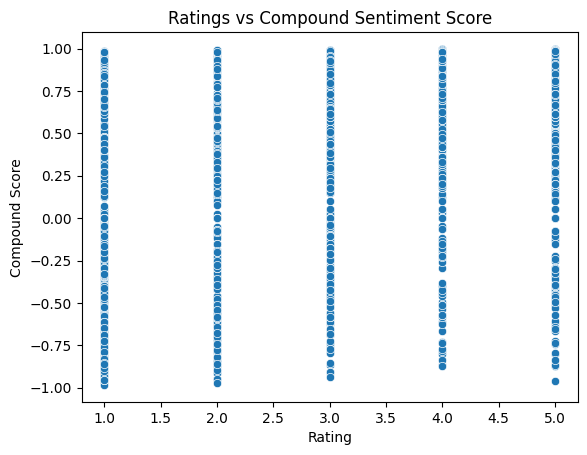

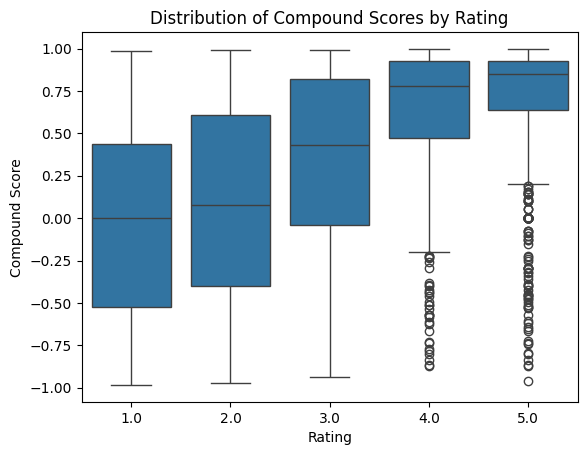

In [17]:
# Scatterplot: Ratings vs Compound Score
sns.scatterplot(data=shoe_data, x='review_rating', y='compound_score')
plt.title('Ratings vs Compound Sentiment Score')
plt.xlabel('Rating')
plt.ylabel('Compound Score')
plt.show()

# Boxplot: Distribution of Compound Scores for Each Rating
sns.boxplot(data=shoe_data, x='review_rating', y='compound_score')
plt.title('Distribution of Compound Scores by Rating')
plt.xlabel('Rating')
plt.ylabel('Compound Score')
plt.show()


In [18]:
#Finding the correlation between the rating and compound score to get the authenticity or if it correct
correlation = shoe_data[['review_rating', 'compound_score']].corr().iloc[0, 1]
print(f"Correlation between rating and compound_score: {correlation:.2f}")


Correlation between rating and compound_score: 0.56


This is not a robust method for sentiment analysis

In [19]:
#Sentiment analysis using RoBERTa model
# Load pre-trained RoBERTa model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

2024-12-19 14:57:14.174572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
def get_all_sentiment_scores(text):
    # Tokenize and encode the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)

    # Softmax to get probabilities for negative, neutral, and positive
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Extract the probability values for negative, neutral, and positive sentiments
    negative_score = probabilities[0, 0].item()  # Probability of negative sentiment
    neutral_score = probabilities[0, 1].item()   # Probability of neutral sentiment
    positive_score = probabilities[0, 2].item()  # Probability of positive sentiment

    # Calculate the sentiment score (positive - negative)
    sentiment_score = positive_score - negative_score

    return sentiment_score, negative_score, neutral_score, positive_score

# Apply the function to get all sentiment scores and add them to the dataframe
shoe_data[['sentiment_score', 'negative_score', 'neutral_score', 'positive_score']] = shoe_data['review_text'].apply(lambda x: pd.Series(get_all_sentiment_scores(x)))
shoe_data.head()


,product_name,review_title,review_text,review_rating,review_date,brand_name,length,compound_score,sentiment_score,negative_score,neutral_score,positive_score
0,klasified women's transparent clear sneaker sh...,Love em,Love these. Was looking for converses and thes...,5.0,Reviewed in the United States on 2 June 2020,Klasified,211,0.8517,0.981647,0.002352,0.013648,0.984000
1,klasified women's transparent clear sneaker sh...,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,Reviewed in the United States on 28 October 2021,Klasified,365,0.6593,-0.576352,0.644515,0.287323,0.068162
2,klasified women's transparent clear sneaker sh...,Good quality,Good quality,5.0,Reviewed in the United States on 20 January 2021,Klasified,12,0.4404,0.615176,0.029417,0.325991,0.644592
3,klasified women's transparent clear sneaker sh...,Good,Great,5.0,Reviewed in the United States on 22 April 2021,Klasified,5,0.6249,0.665226,0.033833,0.267108,0.699059
4,"adidas women's retrorun shoes running, core bl...",Perfect right outta the box,True to size. If between I'd probably go with ...,5.0,Reviewed in Canada on 20 October 2021,Adidas,322,0.4048,0.802767,0.012108,0.173017,0.814875


In [21]:
# Calculate the correlation for each sentiment score with the rating
negative_corr, _ = pearsonr(shoe_data['review_rating'], shoe_data['negative_score'])
neutral_corr, _ = pearsonr(shoe_data['review_rating'], shoe_data['neutral_score'])
positive_corr, _ = pearsonr(shoe_data['review_rating'], shoe_data['positive_score'])

# Print the results
print(f"Correlation between Rating and Negative Sentiment: {negative_corr:.2f}")
print(f"Correlation between Rating and Neutral Sentiment: {neutral_corr:.2f}")
print(f"Correlation between Rating and Positive Sentiment: {positive_corr:.2f}")

Correlation between Rating and Negative Sentiment: -0.78
Correlation between Rating and Neutral Sentiment: -0.38
Correlation between Rating and Positive Sentiment: 0.77


In [22]:
correlation = shoe_data[['review_rating', 'sentiment_score']].corr().iloc[0, 1]
print(f"Correlation between rating and sentiment_score: {correlation:.2f}")

Correlation between rating and sentiment_score: 0.80


# Using an example to show the difference between VADER and RoBERTa model

In [23]:
sia.polarity_scores('The shoes are very cute, but after the 2nd day of wearing them the tongue started ripping. After the 3rd day of wearing them the plastic on the side ripped. They could have ripped bc I was wearing them to work and I do a lot of walking at work. If you’re going to buy these I don’t recommend wearing them on days where you will do a lot of walking or they might rip')['compound']

0.6593

In [24]:
inputs = tokenizer('The shoes are very cute, but after the 2nd day of wearing them the tongue started ripping. After the 3rd day of wearing them the plastic on the side ripped. They could have ripped bc I was wearing them to work and I do a lot of walking at work. If you’re going to buy these I don’t recommend wearing them on days where you will do a lot of walking or they might rip', return_tensors="pt", truncation=True, padding=True, max_length=512)
outputs = model(**inputs)

 # Softmax to get probabilities for negative, neutral, and positive
probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

# Extract the probability values for negative, neutral, and positive sentiments
negative_score = probabilities[0, 0].item()  # Probability of negative sentiment
neutral_score = probabilities[0, 1].item()   # Probability of neutral sentiment
positive_score = probabilities[0, 2].item()  # Probability of positive sentiment

# Calculate the sentiment score (positive - negative)
sentiment_score = positive_score - negative_score
sentiment_score

-0.5763523802161217

# Using Metrics to check the performance of VADER and RoBERTa model

In [25]:
# Map ratings to sentiment labels
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

# Create 'true_sentiment' column from ratings
shoe_data['true_sentiment'] = shoe_data['review_rating'].apply(map_rating_to_sentiment)

# Define thresholds to classify sentiment
def classify_sentiment_sia(compound_score):
    if compound_score > 0.05:
        return 'positive'
    elif compound_score < -0.05:
        return 'negative'
    else:
        return 'neutral'

def classify_sentiment_bert(sentiment_score):
    if sentiment_score > 0.5:
        return 'positive'
    elif sentiment_score < -0.5:
        return 'negative'
    else:
        return 'neutral'

# Classify using both methods
shoe_data['sia_sentiment'] = shoe_data['compound_score'].apply(classify_sentiment_sia)
shoe_data['bert_sentiment'] = shoe_data['sentiment_score'].apply(classify_sentiment_bert)

# Compute metrics for both methods
metrics = {}
for method in ['sia_sentiment', 'bert_sentiment']:
    metrics[method] = {
        'Accuracy': accuracy_score(shoe_data['true_sentiment'], shoe_data[method]),
        'Precision': precision_score(shoe_data['true_sentiment'], shoe_data[method], average='weighted'),
        'Recall': recall_score(shoe_data['true_sentiment'], shoe_data[method], average='weighted'),
        'F1-Score': f1_score(shoe_data['true_sentiment'], shoe_data[method], average='weighted'),
    }

# Compare the metrics
metrics_df = pd.DataFrame(metrics)
metrics_df


,sia_sentiment,bert_sentiment
Accuracy,0.754137,0.784082
Precision,0.711931,0.830398
Recall,0.754137,0.784082
F1-Score,0.726892,0.802173


In [26]:
#Get the important topics which people are talking about in the review
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing spaces
    return text

shoe_data['cleaned_review'] = shoe_data['review_text'].apply(clean_text)

In [28]:
# Function to normalize topics by sorting words
def normalize_topic(topic):
    return " ".join(sorted(topic.split()))

# Define a function to get top words per topic
def get_top_words_per_topic(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[-no_top_words:]])
        # Normalize the topic by sorting words
        normalized_topic = normalize_topic(top_words)
        topics.append(normalized_topic)
    return topics

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
dtm = vectorizer.fit_transform(shoe_data['cleaned_review'])

# Initialize a Counter to track topics across runs
topic_counter = Counter()

# Run LDA 15 times and track topics
for run in range(15):
    print(f"Run {run + 1}:")
    lda_model = LatentDirichletAllocation(n_components=5, max_iter=100, random_state=42)  # Stabilized
    lda_model.fit(dtm)

    # Get normalized top words for each topic
    topics = get_top_words_per_topic(lda_model, vectorizer.get_feature_names_out(), 10)
    print(f"Normalized Topics for run {run + 1}: {topics}")

    # Add normalized topics to the counter
    topic_counter.update(topics)

# Get the 5 most common topics across all runs
most_common_topics = topic_counter.most_common(5)
print("\n5 Most Common Topics Across All Runs:")
for idx, (topic, count) in enumerate(most_common_topics, 1):
    print(f"{idx}. {topic} (Appeared {count} times)")


Run 1:
Normalized Topics for run 1: ['comfortable day feet great like pair shoe shoes support wear', 'good just leather like new pair price quality shoe shoes', 'comfortable daughter fit great love loves pair perfect shoes son', '12 fit half ordered shoe shoes size small wear wide', 'bit feet fit foot heel like little really shoe wide']
Run 2:
Normalized Topics for run 2: ['comfortable day feet great like pair shoe shoes support wear', 'good just leather like new pair price quality shoe shoes', 'comfortable daughter fit great love loves pair perfect shoes son', '12 fit half ordered shoe shoes size small wear wide', 'bit feet fit foot heel like little really shoe wide']
Run 3:
Normalized Topics for run 3: ['comfortable day feet great like pair shoe shoes support wear', 'good just leather like new pair price quality shoe shoes', 'comfortable daughter fit great love loves pair perfect shoes son', '12 fit half ordered shoe shoes size small wear wide', 'bit feet fit foot heel like little re

In [29]:
# Convert the list of most common topics to a DataFrame
most_common_topics_df = pd.DataFrame(most_common_topics, columns=['Topic', 'Frequency'])

# Save the DataFrame to a CSV file
most_common_topics_df.to_csv('most_common_topics.csv', index=False)

print("Most common topics saved to 'most_common_topics.csv'.")

Most common topics saved to 'most_common_topics.csv'.


In [30]:
# Define the topic-to-aspect mapping based on LDA topic words
#Aspect mapping for each review
topic_aspect_map = {
    0: 'General Sentiment/Comfort',               
    1: 'Durability and Longevity',  
    2: 'Size/Adjustments',           
    3: 'Size/Fitting',   
    4: 'Activity-Related Comfort'    
}


# Ensure the same vectorizer and LDA model are applied
def assign_aspect_to_review(review):
    # Transform the review into topic distribution
    review_vectorized = vectorizer.transform([review])  # Use the original vectorizer
    topic_distribution = lda_model.transform(review_vectorized)  # Use the trained LDA model

    # Find the topic with the highest probability
    dominant_topic = topic_distribution.argmax()

    # Map the dominant topic to its corresponding aspect
    return topic_aspect_map.get(dominant_topic, 'Unknown')  # Return 'Unknown' if no match found

# Apply the function to the cleaned_review column
shoe_data['aspect'] = shoe_data['cleaned_review'].apply(assign_aspect_to_review)

# Check the results
shoe_data[['cleaned_review', 'aspect']].head()


,cleaned_review,aspect
0,love these was looking for converses and these...,Size/Adjustments
1,the shoes are very cute but after the 2nd day ...,General Sentiment/Comfort
2,good quality,Durability and Longevity
3,great,Size/Adjustments
4,true to size if between id probably go with yo...,General Sentiment/Comfort


In [31]:
#Collective score of each aspect
aspect_sentiments = shoe_data.groupby('aspect')[['positive_score', 'neutral_score', 'negative_score']].mean()

aspect_sentiments

,positive_score,neutral_score,negative_score
aspect,,,
Activity-Related Comfort,0.529032,0.226708,0.244260
Durability and Longevity,0.444190,0.201053,0.354756
General Sentiment/Comfort,0.704135,0.154674,0.141191
Size/Adjustments,0.883884,0.069656,0.046461
Size/Fitting,0.606242,0.203777,0.189981


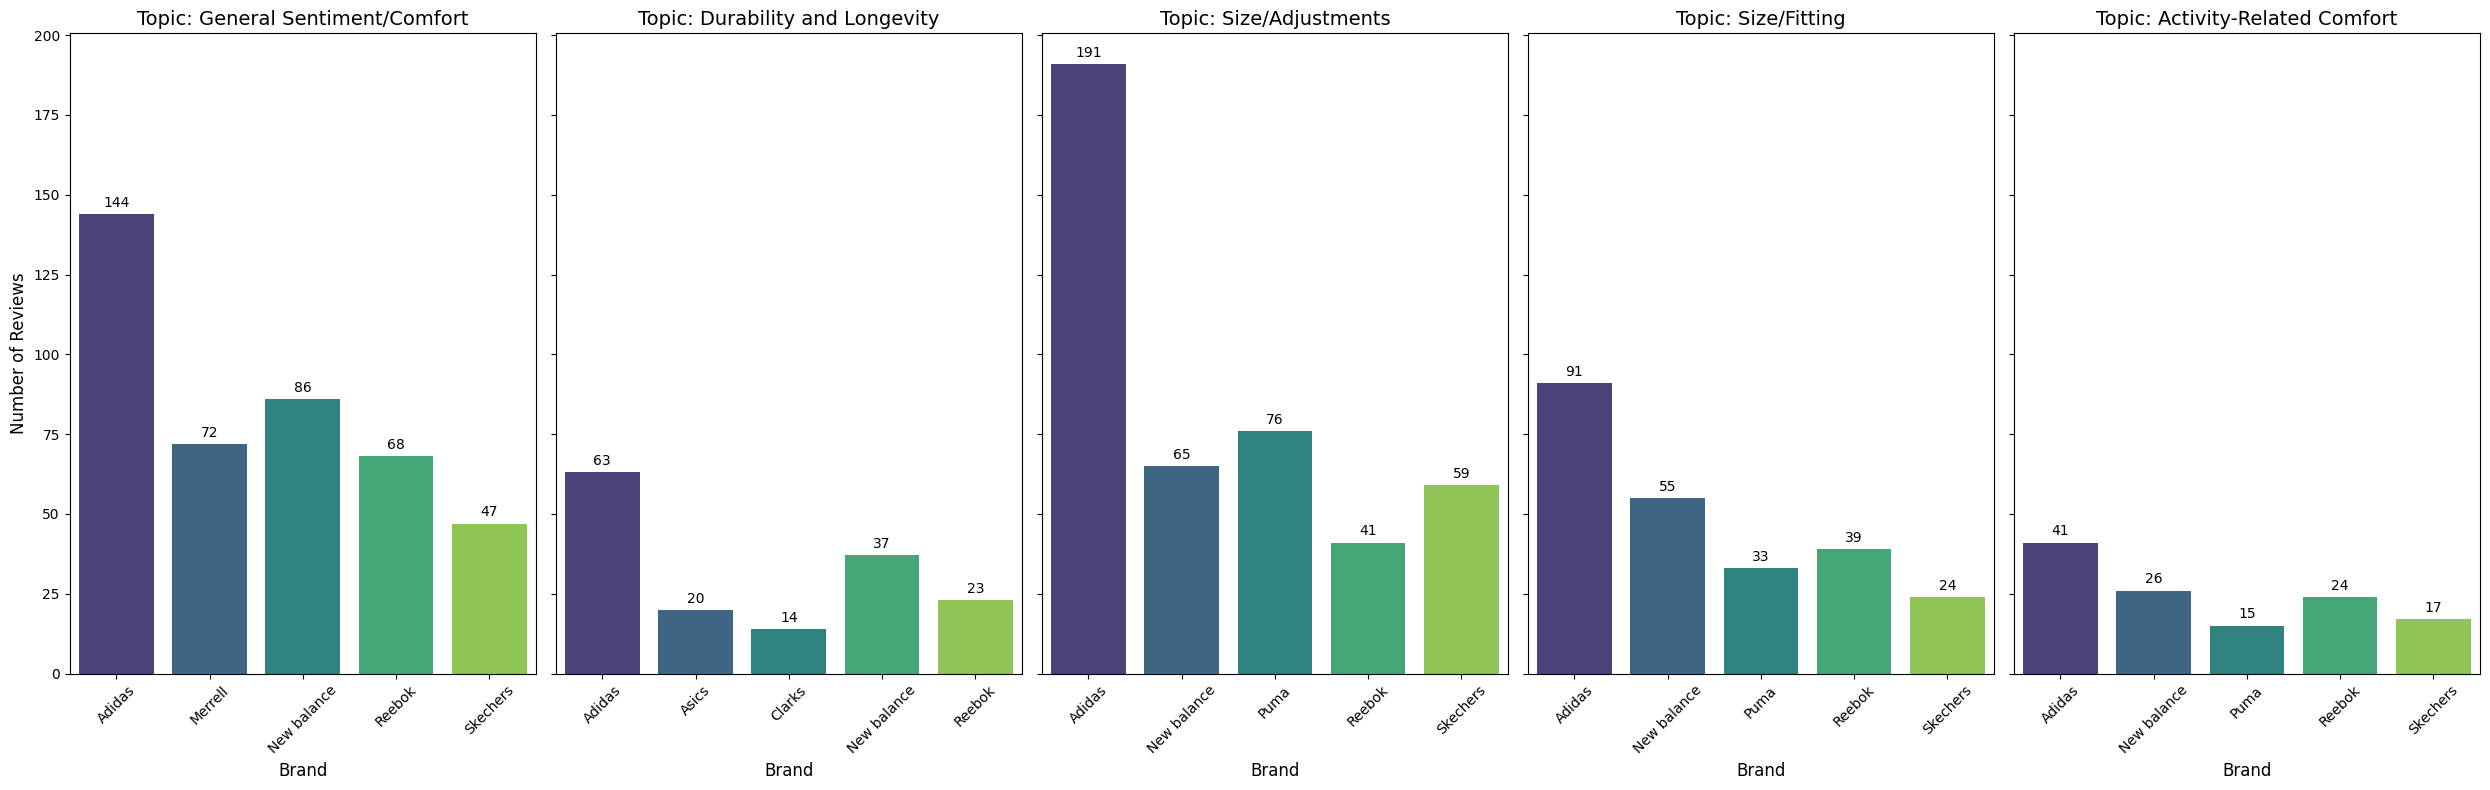

In [32]:
#Get the top brand for each aspect
# Filter the dataset for reviews with a positive sentiment
positive_reviews = shoe_data[shoe_data['positive_score'] > shoe_data['negative_score']]

# Group by 'brand_name' and 'aspect' to count the number of positive reviews
topic_distribution_by_brand = (
    positive_reviews.groupby(['brand_name', 'aspect'])
    .size()
    .reset_index(name='count')
)

# Create subplots for each topic
fig, axes = plt.subplots(1, 5, figsize=(25, 8), sharey=True)

# Loop through each topic and create a bar plot
for idx, topic in enumerate(topic_aspect_map.values()):
    # Filter data for the current topic
    topic_data = topic_distribution_by_brand[topic_distribution_by_brand['aspect'] == topic]

    # Get the top 5 brands for this topic
    top_brands = topic_data.groupby('brand_name')['count'].sum().nlargest(5).index
    topic_data_filtered = topic_data[topic_data['brand_name'].isin(top_brands)]

    # Generate a unique palette for the brands
    brand_palette = sns.color_palette("viridis", len(top_brands))

    # Create a barplot
    sns.barplot(
        data=topic_data_filtered,
        x='brand_name',
        y='count',
        palette=brand_palette,
        ax=axes[idx]
    )

    # Customize the plot
    axes[idx].set_title(f"Topic: {topic}", fontsize=14)
    axes[idx].set_xlabel("Brand", fontsize=12)
    axes[idx].set_ylabel("Number of Reviews", fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)

    # Add data labels on bars
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


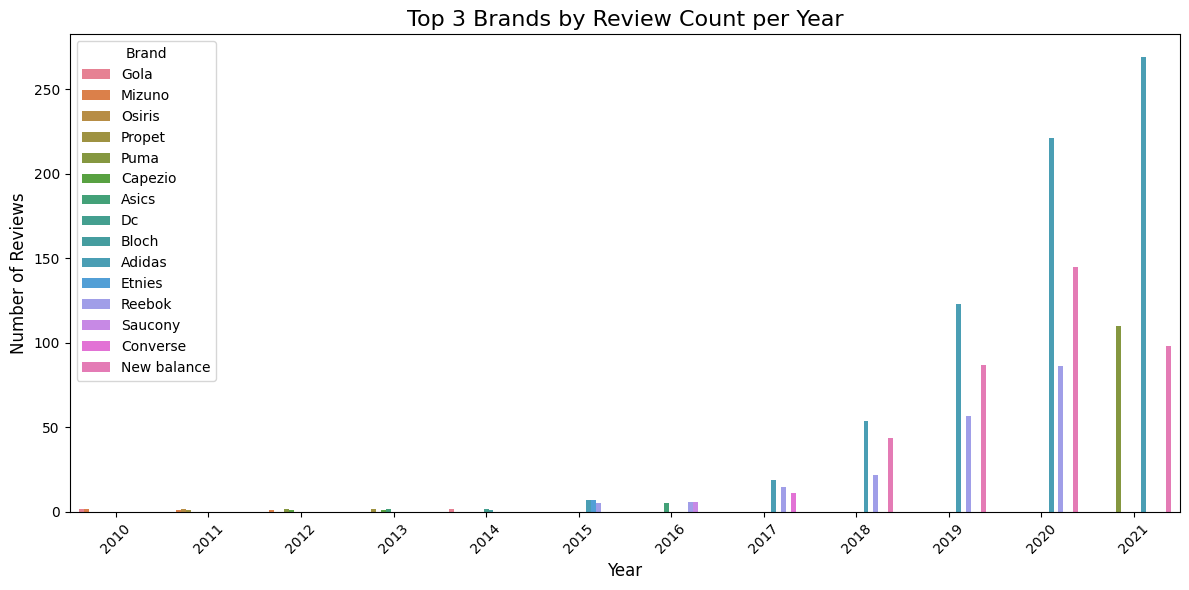

In [33]:
#Get top 3 brands which were sold the most during 2010 to 2021 by counting the review
# Extract the year using string manipulation or regex
shoe_data['year'] = shoe_data['review_date'].str.extract(r'(\d{4})')

# Group by year and brand, then count the number of reviews
yearly_brand_count = shoe_data.groupby(['year', 'brand_name']).size().reset_index(name='count')

# Get the top 3 brands by count for each year
top3_brands_per_year = (
    yearly_brand_count
    .sort_values(['year', 'count'], ascending=[True, False])  # Sort by year and count
    .groupby('year')  # Group by year
    .head(3)  
)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top3_brands_per_year, x='year', y='count', hue='brand_name', dodge=True)

# Customize the plot
plt.title('Top 3 Brands by Review Count per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Brand')

# Show the plot
plt.tight_layout()
plt.show()


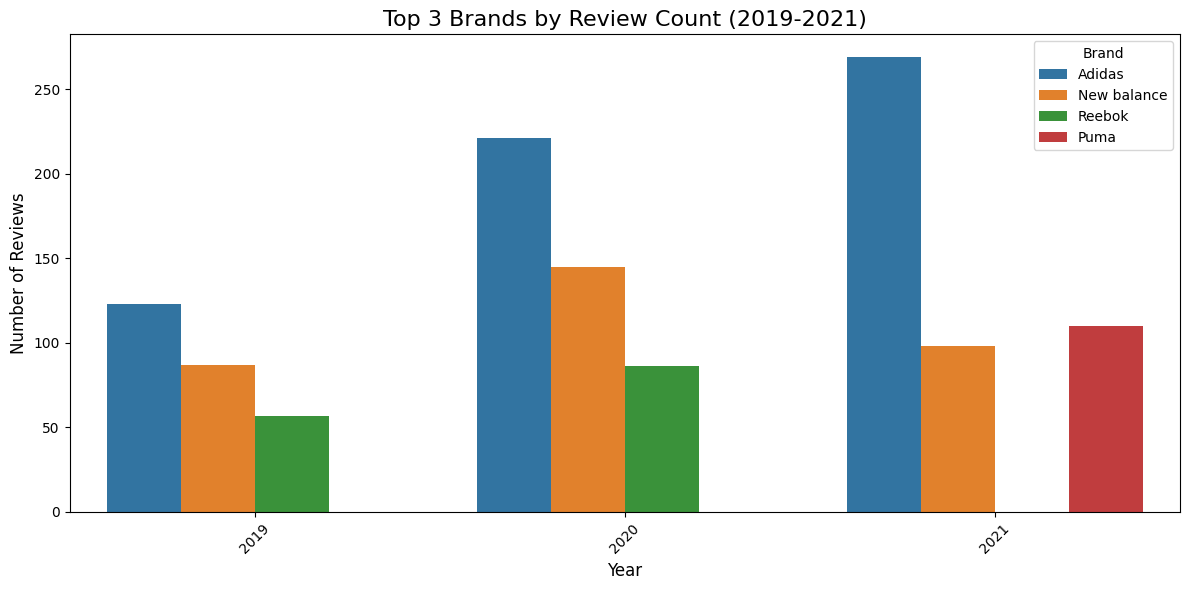

In [34]:
# Filter data for years 2019 to 2021
filtered_data = shoe_data[shoe_data['year'].isin(['2019', '2020', '2021'])]

# Group by year and brand, then count the number of reviews
yearly_brand_count = filtered_data.groupby(['year', 'brand_name']).size().reset_index(name='count')

# Get the top 3 brands by count for each year
top3_brands_per_year = (
    yearly_brand_count
    .sort_values(['year', 'count'], ascending=[True, False])  # Sort by year and count
    .groupby('year')  
    .head(3)  
)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top3_brands_per_year, x='year', y='count', hue='brand_name', dodge=True)

# Customize the plot
plt.title('Top 3 Brands by Review Count (2019-2021)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Brand', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


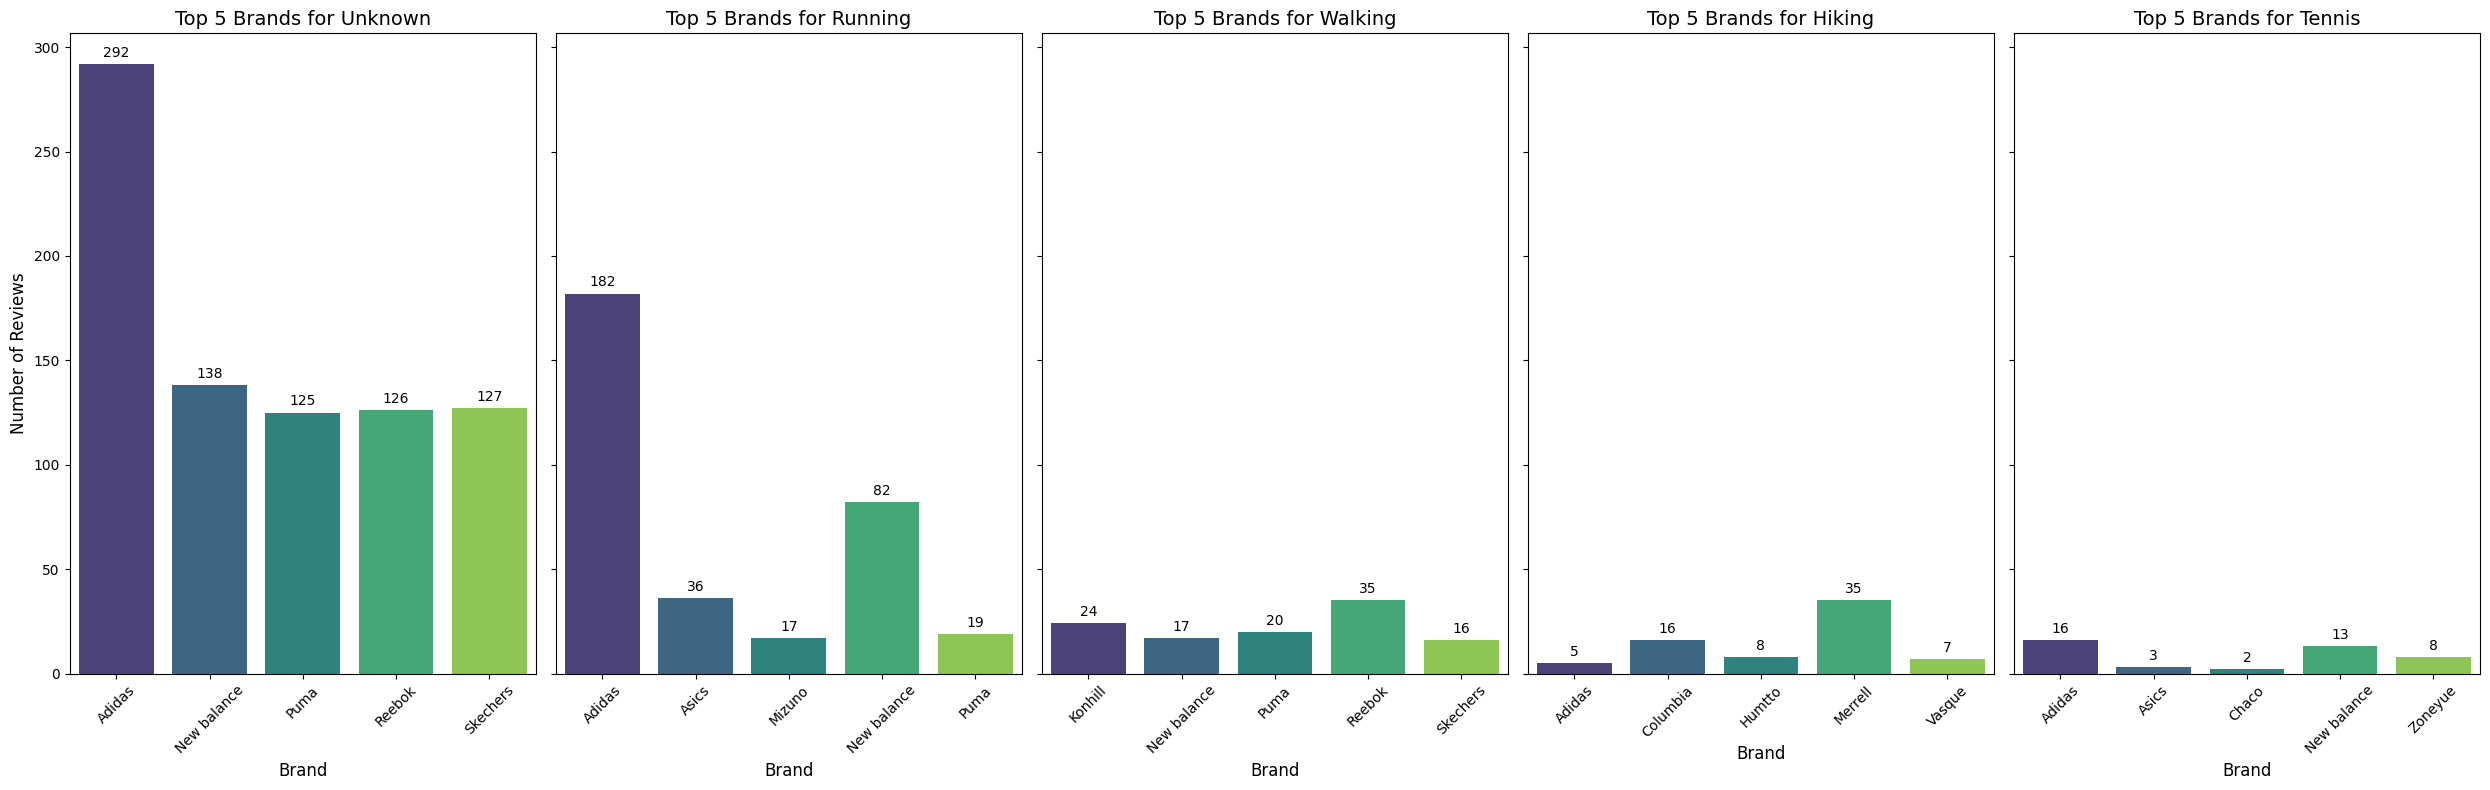

In [35]:
#Getting the brands which are best for which activity by hard coded activities
# Define a list of activity keywords
activities = ['running', 'hiking', 'walking', 'training', 'jogging', 'tennis', 'basketball', 'gym', 'trail']

# Create a regex pattern to match the keywords
activity_pattern = r'\b(' + '|'.join(activities) + r')\b'

# Function to extract the first matching activity from the text
def extract_activity(product_name, review_text):
    # Search in product name first
    match = re.search(activity_pattern, product_name, flags=re.IGNORECASE)
    if match:
        return match.group(0).lower()
    # If not found in product name, search in review text
    match = re.search(activity_pattern, review_text, flags=re.IGNORECASE)
    if match:
        return match.group(0).lower()
    return 'unknown'  # Default if no activity is found

# Apply the function to extract activity
shoe_data['activity'] = shoe_data.apply(lambda row: extract_activity(row['product_name'], row['review_text']), axis=1)

# Filter the dataset for reviews with a positive sentiment
positive_reviews = shoe_data[shoe_data['positive_score'] > shoe_data['negative_score']]

# Group by 'brand_name' and 'activity' to count the number of positive reviews
activity_distribution_by_brand = (
    positive_reviews.groupby(['activity', 'brand_name'])
    .size()
    .reset_index(name='count')
)

# Get the top 5 activities by total positive review count
top_activities = (
    activity_distribution_by_brand.groupby('activity')['count']
    .sum()
    .nlargest(5)
    .index
)

# Filter data for only the top activities
filtered_activity_data = activity_distribution_by_brand[
    activity_distribution_by_brand['activity'].isin(top_activities)
]

# Create subplots for each activity
fig, axes = plt.subplots(1, 5, figsize=(25, 8), sharey=True)

# Loop through each activity and create a bar plot
for idx, activity in enumerate(top_activities):
    # Filter data for the current activity
    activity_data = filtered_activity_data[filtered_activity_data['activity'] == activity]

    # Get the top 5 brands for this activity
    top_brands = activity_data.groupby('brand_name')['count'].sum().nlargest(5).index
    activity_data_filtered = activity_data[activity_data['brand_name'].isin(top_brands)]

    # Generate a unique palette for the brands
    brand_palette = sns.color_palette("viridis", len(top_brands))

    # Create a barplot
    ax = axes[idx]
    sns.barplot(
        data=activity_data_filtered,
        x='brand_name',
        y='count',
        palette=brand_palette,
        ax=ax
    )

    # Customize the plot
    ax.set_title(f"Top 5 Brands for {activity.capitalize()}", fontsize=14)
    ax.set_xlabel("Brand", fontsize=12)
    ax.set_ylabel("Number of Reviews", fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    # Add data labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


Refined Activity Keywords (Before Lemmatization): ['boost', 'condition', 'course', 'goes', 'going', 'gone', 'hiking', 'moving', 'play', 'playing', 'ran', 'range', 'run', 'running', 'runs', 'school', 'tend', 'took', 'trail', 'train', 'training', 'walk', 'walked', 'walking', 'walks', 'went', 'work', 'worked', 'working', 'works']
Top 5 Most Common Activities (After Lemmatization): ['run', 'walk', 'work', 'go', 'hike']


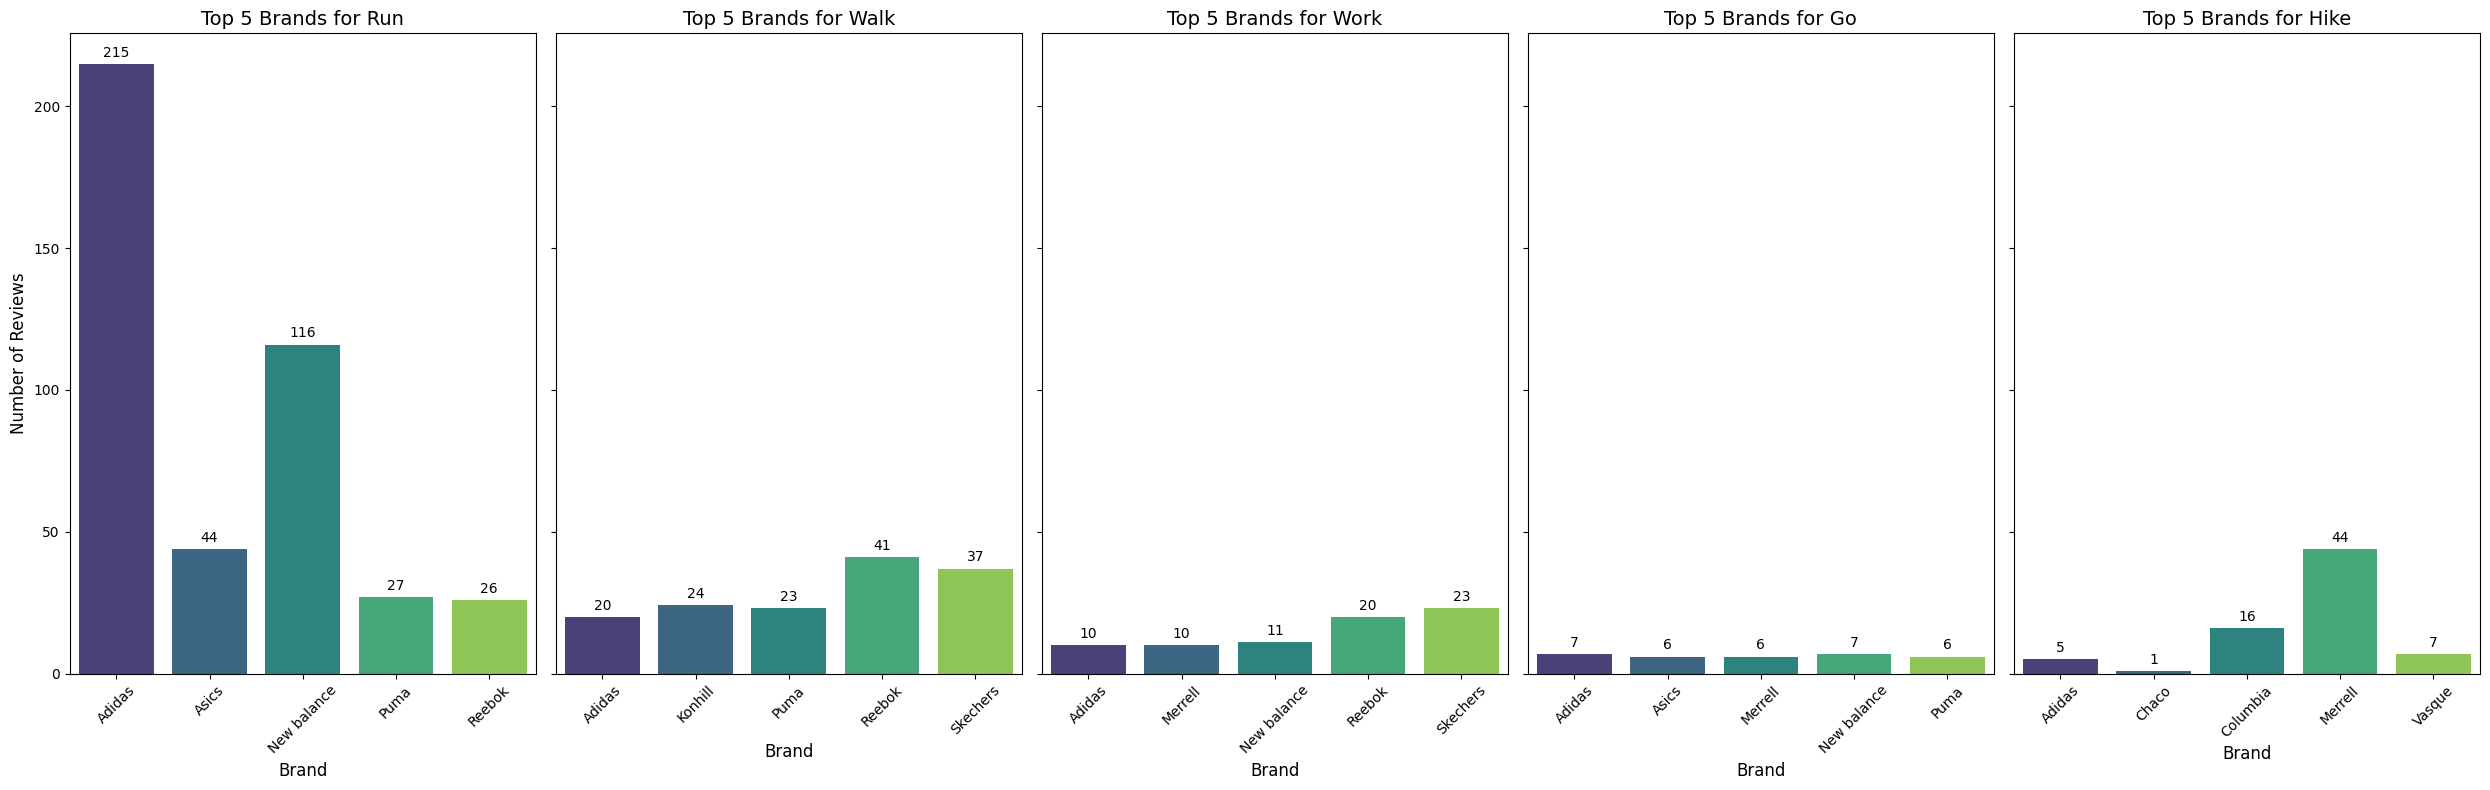

In [36]:
#Getting the brands which are best for which activity by getting activity from review text and product name
# Combine 'product_name' and 'review_text' into a single text field for searching
shoe_data['combined_text'] = shoe_data['product_name'].str.cat(
    shoe_data['review_text'], sep=' ', na_rep=''
)

#Define a function to check if a word is a valid physical activity
def is_valid_activity(word):
    synsets = wn.synsets(word, pos=wn.VERB)  # Check for verb meanings
    for syn in synsets:
        # Look for physical activity-related meanings
        if any(activity in syn.lemma_names() for activity in ['run', 'walk', 'hike', 'train', 'play']):
            return True
    return False

#Extract candidate activity words using TF-IDF and filter them
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenize and preprocess text
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    return text.lower()

shoe_data['combined_text'] = shoe_data['combined_text'].apply(preprocess_text)

# Use TF-IDF to find important words
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # Top 1000 features
tfidf_matrix = vectorizer.fit_transform(shoe_data['combined_text'])

# Extract feature names (words) from TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Filter for valid activity words
valid_activity_keywords = [word for word in feature_names if is_valid_activity(word)]

print("Refined Activity Keywords (Before Lemmatization):", valid_activity_keywords)

#Create a regex pattern for valid activities
activity_pattern = r'\b(' + '|'.join(valid_activity_keywords) + r')\b'

# Extract activities from the text
shoe_data['matched_activities'] = shoe_data['combined_text'].apply(
    lambda x: re.findall(activity_pattern, x.lower())
)

# Apply lemmatization to group similar activities
lemmatizer = WordNetLemmatizer()
shoe_data['matched_activities'] = shoe_data['matched_activities'].apply(
    lambda activities: [lemmatizer.lemmatize(activity, pos='v') for activity in activities]
)

# Flatten and count occurrences of lemmatized activities
all_activities = [activity for activities in shoe_data['matched_activities'] for activity in activities]
activity_counts = Counter(all_activities)

# Get the top 5 most common activities
most_common_activities = [activity for activity, _ in activity_counts.most_common(5)]
print("Top 5 Most Common Activities (After Lemmatization):", most_common_activities)

# Filter data for only the top 5 activities
shoe_data['activity'] = shoe_data['matched_activities'].apply(
    lambda activities: next((a for a in activities if a in most_common_activities), 'unknown')
)
filtered_activity_data = shoe_data[shoe_data['activity'].isin(most_common_activities)]

#  Filter for positive sentiment reviews
positive_reviews = filtered_activity_data[filtered_activity_data['positive_score'] > filtered_activity_data['negative_score']]

# Group by 'brand_name' and 'activity' to count the number of positive reviews
activity_distribution_by_brand = (
    positive_reviews.groupby(['activity', 'brand_name'])
    .size()
    .reset_index(name='count')
)

#Create subplots for each activity
fig, axes = plt.subplots(1, len(most_common_activities), figsize=(25, 8), sharey=True)

# Loop through each activity and create a bar plot
for idx, activity in enumerate(most_common_activities):
    # Filter data for the current activity
    activity_data = activity_distribution_by_brand[activity_distribution_by_brand['activity'] == activity]

    # Get the top 5 brands for this activity
    top_brands = activity_data.groupby('brand_name')['count'].sum().nlargest(5).index
    activity_data_filtered = activity_data[activity_data['brand_name'].isin(top_brands)]
    brand_palette = sns.color_palette("viridis", len(top_brands))
    ax = axes[idx]
    sns.barplot(
        data=activity_data_filtered,
        x='brand_name',
        y='count',
        palette=brand_palette,
        ax=ax
    )

   
    ax.set_title(f"Top 5 Brands for {activity.capitalize()}", fontsize=14)
    ax.set_xlabel("Brand", fontsize=12)
    ax.set_ylabel("Number of Reviews", fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

plt.tight_layout()
plt.show()


hybrid_sentiment
positive             2635
negative              654
neutral               391
slightly negative      74
slightly positive      53
Name: count, dtype: int64

Top 10 Brands for Slightly Positive Sentiments:
           brand_name   hybrid_sentiment  count
50             Reebok  slightly positive      8
1              Adidas  slightly positive      7
7               Asics  slightly positive      4
14   Cambridge select  slightly positive      2
20           Columbia  slightly positive      2
29  Johnston & murphy  slightly positive      2
56               Teva  slightly positive      2
58       Under armour  slightly positive      2
2           Aerosoles  slightly positive      1
4          Anne klein  slightly positive      1

Top 10 Brands for Slightly Negative Sentiments:
     brand_name   hybrid_sentiment  count
0        Adidas  slightly negative     13
49       Reebok  slightly negative     10
41  New balance  slightly negative      9
54     Skechers  slightly negativ

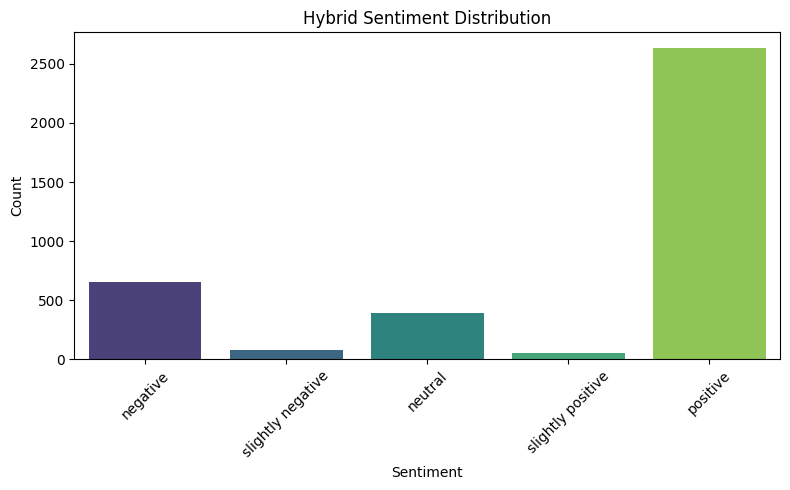

In [37]:
#Getting the slightly positive and slightly negative brand break down using VADER and RoBERTa
SLIGHT_POSITIVE_THRESHOLD_COMPOUND = (0.05, 0.25)
SLIGHT_NEGATIVE_THRESHOLD_COMPOUND = (-0.25, -0.05)

def hybrid_sentiment_analysis(row):
    # Extract scores from existing columns
    compound_score = row['compound_score']
    positive_score = row['positive_score']
    negative_score = row['negative_score']
    neutral_score = row['neutral_score']
    
    # Determine primary sentiment using RoBERTa
    if positive_score > max(negative_score, neutral_score):
        roberta_sentiment = "positive"
    elif negative_score > max(positive_score, neutral_score):
        roberta_sentiment = "negative"
    else:
        roberta_sentiment = "neutral"
    
    # Use VADER compound score to determine slight sentiments
    if SLIGHT_POSITIVE_THRESHOLD_COMPOUND[0] < compound_score <= SLIGHT_POSITIVE_THRESHOLD_COMPOUND[1]:
        if roberta_sentiment == "positive":
            return "slightly positive"
    elif SLIGHT_NEGATIVE_THRESHOLD_COMPOUND[0] <= compound_score < SLIGHT_NEGATIVE_THRESHOLD_COMPOUND[1]:
        if roberta_sentiment == "negative":
            return "slightly negative"
    
    # If mismatch or not slight, fallback to RoBERTa sentiment
    return roberta_sentiment

# Apply the hybrid sentiment analysis to the dataset
shoe_data['hybrid_sentiment'] = shoe_data.apply(hybrid_sentiment_analysis, axis=1)

# Display sentiment counts
print(shoe_data['hybrid_sentiment'].value_counts())

# Brand name breakdown for slight positive and slight negative sentiments
brand_name_breakdown = shoe_data[shoe_data['hybrid_sentiment'].isin(['slightly positive', 'slightly negative'])]
brand_name_breakdown = brand_name_breakdown.groupby(['brand_name', 'hybrid_sentiment']).size().reset_index(name='count')

# Get top 10 brands for slightly positive sentiment
slightly_positive_top_brands = (
    brand_name_breakdown[brand_name_breakdown['hybrid_sentiment'] == 'slightly positive']
    .nlargest(10, 'count')
)
print("\nTop 10 Brands for Slightly Positive Sentiments:")
print(slightly_positive_top_brands)

# Get top 10 brands for slightly negative sentiment
slightly_negative_top_brands = (
    brand_name_breakdown[brand_name_breakdown['hybrid_sentiment'] == 'slightly negative']
    .nlargest(10, 'count')
)
print("\nTop 10 Brands for Slightly Negative Sentiments:")
print(slightly_negative_top_brands)
# Visualization of hybrid sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=shoe_data, x='hybrid_sentiment', palette='viridis', 
              order=['negative', 'slightly negative', 'neutral', 'slightly positive', 'positive'])
plt.title('Hybrid Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Slightly Positive Reviews:
Top Positive Points: [('size', 3.1676719279735703), ('cute', 3.117619968856962), ('great', 2.9316027478562092), ('comfy', 2.3428017116975117), ('run', 2.2680191318269736), ('comfortable', 2.082470178505071), ('look', 1.5499396489693136), ('small', 1.4390842101621533), ('little', 1.4379377167465397), ('box', 1.3820854056520844)]
Top Negative Points: [('feel', 1.5854160111168318), ('feet', 1.3161679363618688), ('cushion', 1.2127681327103301), ('step', 1.2127681327103301), ('worn', 1.0922652531054498), ('inside', 1.0267511280883146), ('time', 1.0259102552908423), ('leather', 0.9461426339779512), ('long', 0.8899012802518813), ('marks', 0.867163631983193)]
Top Reasons (from 'because' or 'cause') in Negative Sentences: []

Slightly Negative Reviews:
Top Positive Points: [('fit', 2.8290178041022735), ('size', 2.0826643972893306), ('constructed', 2.0), ('support', 1.9323919511041583), ('looked', 1.883628156481182), ('wear', 1.7203024443032577), ('look', 1.67382913323

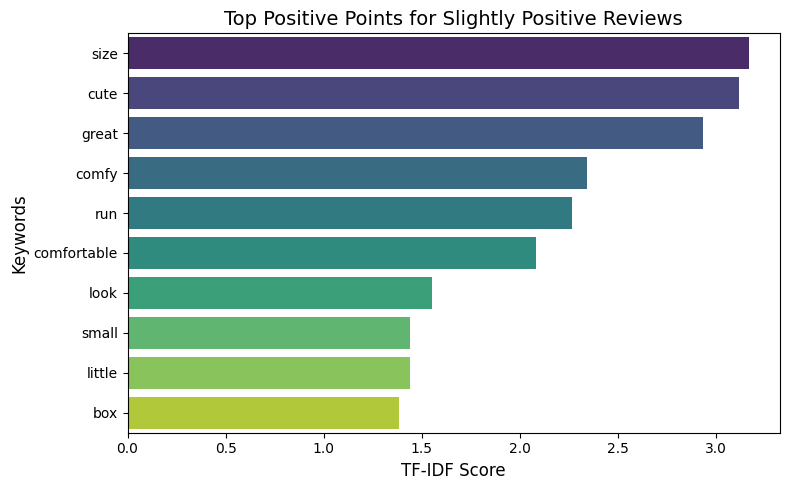

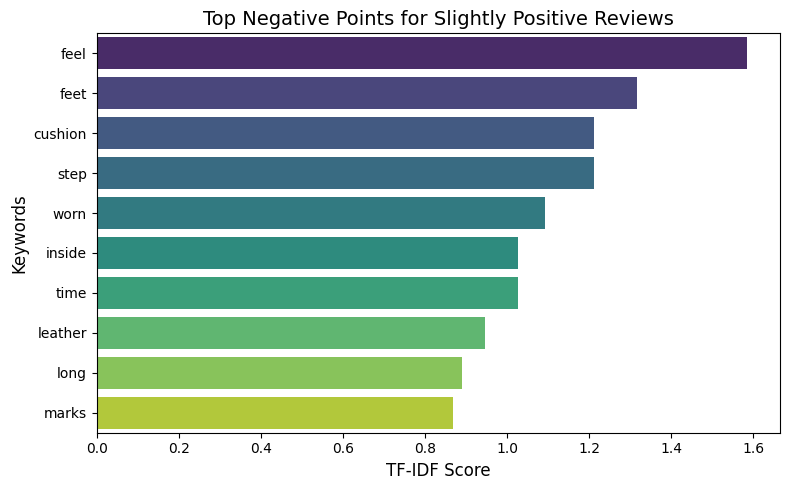

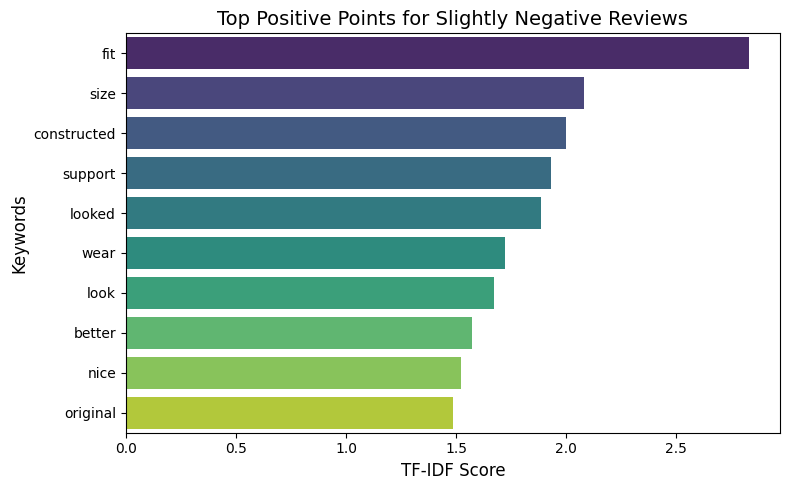

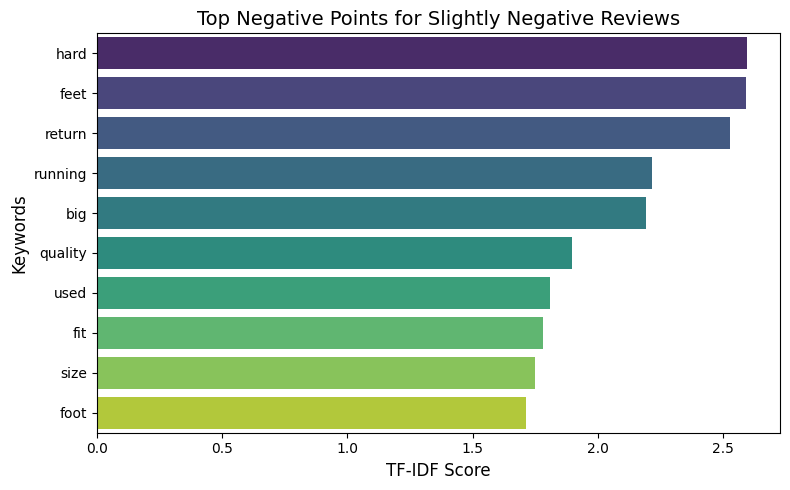

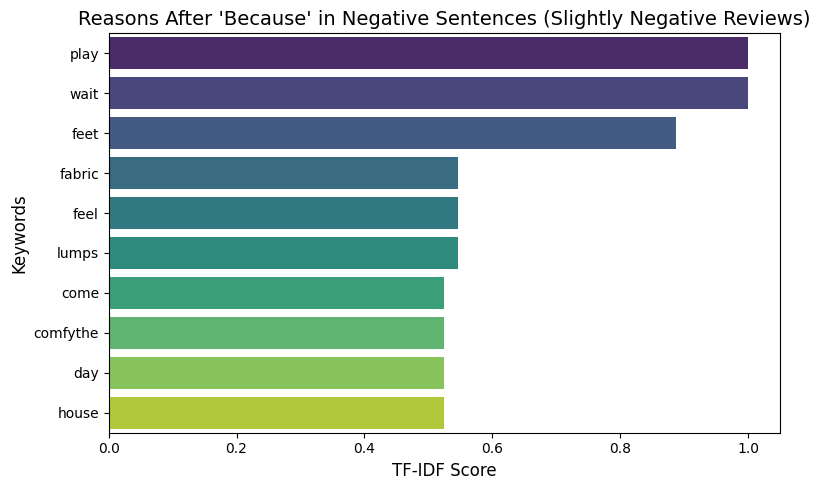

In [38]:
#Slightly positive and negative are taken and positive and negative factors are extracted along 
#with that the reson factor of negative sentences only of these slight positive and negative
custom_stopwords = set(ENGLISH_STOP_WORDS).union(stopwords.words('english'), {"shoes", "shoe", "pair", "buy", "like", "one", "really", "disappoint", "disappointed", "disappointing", "recommend", "problem", "problematic", "dislikes", "complaints", "complaint", "product", "im", "favorites", "regrets", "good"})

# Function to clean text by removing stop words and punctuation
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and convert to lowercase
    words = [word for word in text.split() if word not in custom_stopwords]  # Remove stop words
    return " ".join(words)

# Function to classify sentences into positive or negative
def analyze_review_sentiment(review):
    sentences = sent_tokenize(review)
    positive_sentences = []
    negative_sentences = []

    for sentence in sentences:
        score = sia.polarity_scores(sentence)
        if score['compound'] > 0.05:  # Positive sentence
            positive_sentences.append(sentence)
        elif score['compound'] < -0.05:  # Negative sentence
            negative_sentences.append(sentence)

    return positive_sentences, negative_sentences

# Function to extract phrases after "because" or "cause" from negative sentences
def extract_phrases_after_keywords(sentences, keywords=['because', 'cause', 'due to', 'reason'], exclusions=['was not', 'does not', "wasn't", "doesn't"]):
    extracted_phrases = []
    for sentence in sentences:
        for keyword in keywords:
            match = re.search(rf'\b{keyword}\b(.*)', sentence, re.IGNORECASE)
            if match:
                phrase = match.group(1).strip()
                if not any(exclusion in phrase for exclusion in exclusions):
                    extracted_phrases.append(phrase)
    return extracted_phrases

# Function to analyze slightly positive and slightly negative reviews
def analyze_slight_sentiments_and_reasons(reviews, top_n=10):
    positive_phrases = []
    negative_phrases = []
    because_phrases_from_negative = []

    for review in reviews:
        # Break down into positive and negative sentences
        pos_sentences, neg_sentences = analyze_review_sentiment(review)
        positive_phrases.extend(pos_sentences)
        negative_phrases.extend(neg_sentences)

        # Extract "because" phrases only from negative sentences
        because_phrases_from_negative.extend(extract_phrases_after_keywords(neg_sentences))

    # Clean phrases
    positive_phrases_cleaned = [clean_text(phrase) for phrase in positive_phrases]
    negative_phrases_cleaned = [clean_text(phrase) for phrase in negative_phrases]
    because_phrases_cleaned = [clean_text(phrase) for phrase in because_phrases_from_negative]

    # TF-IDF Analysis
    vectorizer = TfidfVectorizer(max_features=500)

    # Positive TF-IDF
    positive_keywords = {}
    if positive_phrases_cleaned:
        positive_tfidf = vectorizer.fit_transform(positive_phrases_cleaned)
        positive_keywords = dict(zip(vectorizer.get_feature_names_out(), positive_tfidf.sum(axis=0).A1))

    # Negative TF-IDF
    negative_keywords = {}
    if negative_phrases_cleaned:
        negative_tfidf = vectorizer.fit_transform(negative_phrases_cleaned)
        negative_keywords = dict(zip(vectorizer.get_feature_names_out(), negative_tfidf.sum(axis=0).A1))

    # "Because" TF-IDF
    because_keywords = {}
    if because_phrases_cleaned:
        because_tfidf = vectorizer.fit_transform(because_phrases_cleaned)
        because_keywords = dict(zip(vectorizer.get_feature_names_out(), because_tfidf.sum(axis=0).A1))

    return (Counter(positive_keywords).most_common(top_n),
            Counter(negative_keywords).most_common(top_n),
            Counter(because_keywords).most_common(top_n))

# Filter for slightly positive and slightly negative reviews
slight_sentiments = shoe_data[shoe_data['hybrid_sentiment'].isin(['slightly positive', 'slightly negative'])]

# Extract slightly positive and slightly negative reviews
slightly_positive_reviews = slight_sentiments[slight_sentiments['hybrid_sentiment'] == 'slightly positive']['review_text']
slightly_negative_reviews = slight_sentiments[slight_sentiments['hybrid_sentiment'] == 'slightly negative']['review_text']

# Analyze slightly positive reviews
slightly_positive_results = analyze_slight_sentiments_and_reasons(slightly_positive_reviews, top_n=10)
positive_reasons, positive_drawbacks, positive_because_reasons = slightly_positive_results

# Analyze slightly negative reviews
slightly_negative_results = analyze_slight_sentiments_and_reasons(slightly_negative_reviews, top_n=10)
negative_reasons, negative_drawbacks, negative_because_reasons = slightly_negative_results

# Display results
print("Slightly Positive Reviews:")
print("Top Positive Points:", positive_reasons)
print("Top Negative Points:", positive_drawbacks)
print("Top Reasons (from 'because' or 'cause') in Negative Sentences:", positive_because_reasons)

print("\nSlightly Negative Reviews:")
print("Top Positive Points:", negative_reasons)
print("Top Negative Points:", negative_drawbacks)
print("Top Reasons (from 'because' or 'cause') in Negative Sentences:", negative_because_reasons)

# Function to plot results
def plot_reasons(reasons, title):
    if reasons:
        words, scores = zip(*reasons)
        plt.figure(figsize=(8, 5))
        sns.barplot(x=list(scores), y=list(words), palette="viridis")
        plt.title(title, fontsize=14)
        plt.xlabel("TF-IDF Score", fontsize=12)
        plt.ylabel("Keywords", fontsize=12)
        plt.tight_layout()
        plt.show()

# Plot for slightly positive reviews
plot_reasons(positive_reasons, "Top Positive Points for Slightly Positive Reviews")
plot_reasons(positive_drawbacks, "Top Negative Points for Slightly Positive Reviews")
plot_reasons(positive_because_reasons, "Reasons After 'Because' in Negative Sentences (Slightly Positive Reviews)")

# Plot for slightly negative reviews
plot_reasons(negative_reasons, "Top Positive Points for Slightly Negative Reviews")
plot_reasons(negative_drawbacks, "Top Negative Points for Slightly Negative Reviews")
plot_reasons(negative_because_reasons, "Reasons After 'Because' in Negative Sentences (Slightly Negative Reviews)")


In [40]:
import random

# Filter for slightly positive reviews
slightly_positive_reviews = shoe_data[shoe_data['hybrid_sentiment'] == 'slightly positive']['review_text']

# Randomly select one review
if not slightly_positive_reviews.empty:
    random_sentence = random.choice(slightly_positive_reviews.tolist())
    print("Random Slightly Positive Sentence:")
    print(random_sentence)
else:
    print("No reviews marked as slightly positive.")


Random Slightly Positive Sentence:
Beautiful “I wear size is 9 base on the chart size I take 8.5 but the material the rubber soles are too hard in general the whole material
